
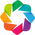

In [27]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 8)
import holoviews as hv
hv.extension('bokeh', 'matplotlib')
from holoext.bokeh import Mod


## Generate fake data

In [2]:
X = np.random.randn(1000, 1).astype('float32')
noise = 2 * np.random.randn(1000, 1).astype('float32')
Y = 4 * X + 3 + noise

In [3]:
Mod().apply(hv.Scatter((X, Y)))

:Scatter   [x]   (y)

## Create a sklearn LinearRegression instance and use it

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [30]:
LR = LinearRegression()

In [31]:
LR.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
y_predict = LR.predict(X)

In [33]:
r2_score(Y, y_predict)

0.8067593331546032

In [8]:
Mod().apply(hv.Scatter((X, Y), group='fit', label='data') * hv.Curve((X, y_predict), group='fit', label='fitted-line'))

:Overlay
   .Fit.Data                     :Scatter   [x]   (y)
   .Fit.Fitted_hyphen_minus_line :Curve   [x]   (y)

## PyMC3

### Set up the PyMC3 model

In [9]:
import pymc3 as pm
import theano

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_d68l24zm.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda0: GeForce 940M (0000:04:00.0)


In [10]:
lin_reg_model = pm.Model()
model_input = theano.shared(X)
model_output = theano.shared(Y)

In [11]:
with lin_reg_model:
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=(1))
    beta = pm.Normal('beta', mu=0, sd=100, shape=(1))

    s = pm.HalfNormal('s', tau=1)
    mean = alpha + beta * model_input
    y = pm.Normal('y', mu=mean, sd=s, observed=model_output)

### Infer Parameters

In [12]:
with lin_reg_model:
    inference = pm.ADVI()
    approx = pm.fit(
        n=20000,
        method=inference,
        more_replacements={
            model_input: pm.Minibatch(X),
            model_output: pm.Minibatch(Y)
        })

Average Loss = 284.59: 100%|██████████| 20000/20000 [00:56<00:00, 355.32it/s]
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 284.6


In [13]:
Mod(xlabel='iteration', ylabel='ELBO').apply(hv.Histogram(-inference.hist))

:Histogram   [x]   (Frequency)

### Interpret your parameters

In [14]:
trace = approx.sample(draws=5000)

In [15]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.934206,0.213527,0.002890,2.508106,3.336002
beta__0,4.021358,0.235127,0.003367,3.559546,4.470907
s,1.978554,0.150535,0.002052,1.707481,2.294679


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd92c462898>,
      dtype=object)

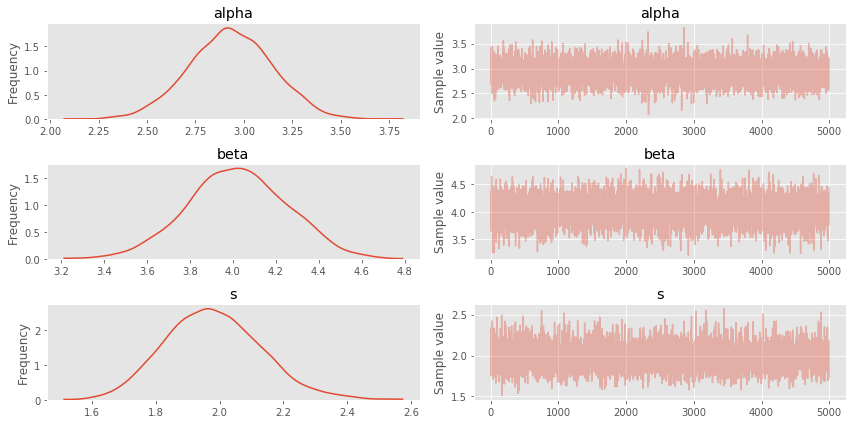

In [16]:
pm.traceplot(trace)

### Predict data by creating posterior predictive samples

In [18]:
ppc = pm.sample_ppc(trace, model=lin_reg_model, samples=2000)

100%|██████████| 2000/2000 [00:07<00:00, 278.71it/s]


In [22]:
ppc['y'].shape

(2000, 1000, 1)

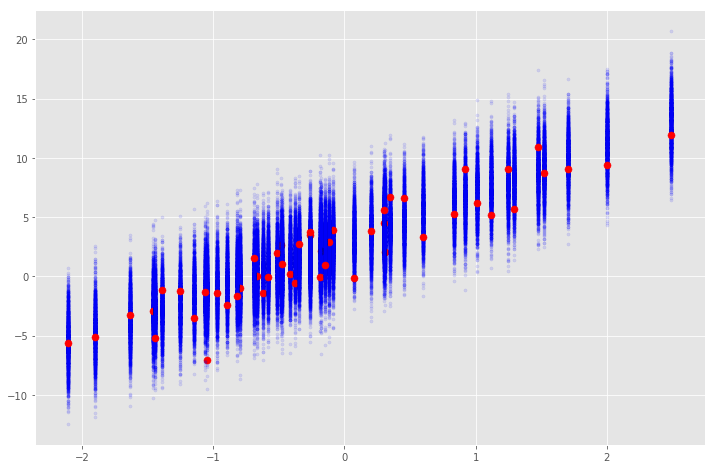

In [28]:
fig2 = plt.figure()
for i in range(50):
    plt.scatter(
        X[i] * np.ones(len(ppc['y'][:, i])),
        ppc['y'][:, i],
        color='b',
        s=10,
        alpha=0.1)
    plt.scatter(X[i], Y[i], color='r', s=50)

In [34]:
pred = ppc['y'].mean(axis=0)

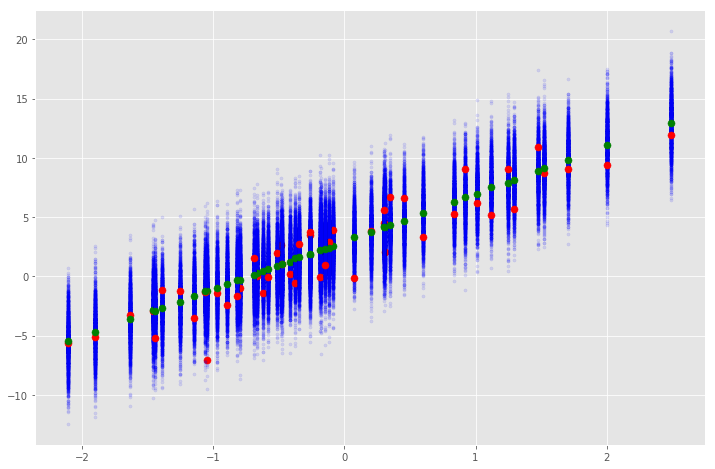

In [35]:
fig3 = plt.figure()
for i in range(50):
    plt.scatter(
        X[i] * np.ones(len(ppc['y'][:, i])),
        ppc['y'][:, i],
        color='b',
        s=10,
        alpha=0.1)
    plt.scatter(X[i], Y[i], color='r', s=50)
    plt.scatter(X[i], pred[i], color='g', s=50)

In [36]:
r2_score(Y, pred)

0.8064487407147302

## Implement Hierarchical Logistic Regression
### Create a BayesianModel Base Class for reusable components

In [40]:
from pymc3_models import LinearRegression

In [41]:
LR = LinearRegression()

In [42]:
LR.fit(X, Y)

Average Loss = 2,113:  18%|█▊        | 35179/200000 [01:28<06:54, 397.53it/s]  
INFO:pymc3.variational.inference:Convergence archived at 35200
INFO:pymc3.variational.inference:Interrupted at 35,199 [17%]: Average Loss = 4,609.7


LinearRegression()

In [43]:
LR.predict(X)

100%|██████████| 2000/2000 [00:05<00:00, 362.26it/s]


array([ 8.23135076e+00,  3.23816367e+00,  2.53302416e+00,  9.82473728e-01,
        4.76956520e+00,  4.14055636e+00, -5.54555743e+00,  1.97297943e+00,
       -4.78498000e+00,  8.79210867e-01,  4.23344499e-01,  2.87540684e-01,
        1.84106332e+00,  6.33820960e+00,  9.07121172e+00,  1.06338125e+00,
        1.26294424e+00,  2.20335331e+00,  1.74316312e-01, -1.70725300e+00,
       -2.66609127e+00, -2.87850950e+00,  3.82906082e+00, -2.65271093e-01,
       -9.88744709e-01,  8.04407811e+00,  9.84642597e+00, -1.14646225e+00,
        1.30613108e+01, -3.68947379e+00,  7.44782937e+00,  2.30989328e+00,
       -2.89318290e+00, -3.53621807e-01,  1.09682258e+01,  2.22867898e+00,
        5.28600442e+00,  6.59938040e+00,  4.06996966e+00, -2.13587209e+00,
        1.39966008e+00,  2.29838065e+00,  4.37290192e+00,  8.92823412e+00,
        4.18804433e+00, -1.34277453e+00, -6.46505366e-01,  1.53428830e+00,
        7.06367933e+00,  5.70694585e-01, -1.95968384e+00,  4.00326143e+00,
        4.43902603e-01,  

In [44]:
LR.score(X, Y)

100%|██████████| 2000/2000 [00:02<00:00, 681.10it/s]


0.8066343050398537